# Comparing a naive neural net using word embeddings to a linear model for prediction of cholesterol content of foods

In [1]:
import sys
import os
from operator import itemgetter
import _pickle as pkl
import random
import pandas
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import *
# from sklearn.linear_model import *
import sklearn
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib import learn
import gensim
import tflearn

/home/andylane/Envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/

## Load data
These were previously collected from a collection of recipes with cholesterol information.

In [2]:
# Load pre-trained Google News word vector embeddings
#model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#model.save("saved_word2vec.mdl")
#del model
model = gensim.models.KeyedVectors.load('saved_word2vec.mdl', mmap='r')

# Load the traning/test data
words = pkl.load(open("tf_data/training_data_names.pkl", "rb")) # this is a stemmed/tokenized version
X = pkl.load(open("tf_data/training_data_names_unstemmed.pkl", "rb")) # Recipe names
y = pkl.load(open("tf_data/training_labels_num.pkl", "rb")) # Corresponding cholesterol content for each recipe

# Slice out 20% for test data. This isn't random. OK for development, but need to go back and check later.
X_test = X[3152:]
y_test = y[3152:]

# The rest is the training data
X = X[:3152]
y = y[:3152]

# We also have some alternative test data from chain restaurant menus, but there are issues
# with testing the model on this. Explain in blog.
ground_truth_X = pkl.load(open("tf_data/test_data_names.pkl", "rb"))
ground_truth_y = pkl.load(open("tf_data/test_labels_num.pkl", "rb"))

In [3]:
# This time we're carrying out the prediction as a regression
# rather than a classification. To start with, an r2 of 
# predicted vs true test cholesterol is used as a metric; the MSE
# is also used.
import scipy
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [4]:
# Notes to self:
## There are 300,000 words in the Google News model
len(model.vocab)

## Get words from given index
model.wv.index2word[2898]
# Out: 'judges"

## Find the odd word out:
model.doesnt_match(X[3].split())

## Access recipes:
print(X[3])
print(words[3])

## Get the similarity between two phrases. This is implemented in gensim as
## just the cosine similarity of the means of the two vectors
model.n_similarity(X[3].split(), X[7].split())
model.similarity("saucepan", "food")

## There's a case for n-gramming with underscores:
model.most_similar(["cinnamon", "roll"])
# Out e.g.: coconut_flakes, graham_cracker_crumbs
model.most_similar("cinnamon_roll")
# Out e.g.: cinnamon_rolls, oatmeal_cookie, peach_pie

Campfire Banana Splits
campfir banana split


[('cinnamon_rolls', 0.655969500541687),
 ('oatmeal_cookie', 0.6287018656730652),
 ('peach_pie', 0.6216853857040405),
 ('banana_walnut', 0.6158987879753113),
 ('baked_beans_peaches', 0.6140761375427246),
 ('waffle_cone', 0.6071436405181885),
 ('fruit_cobbler', 0.6069991588592529),
 ('snickerdoodle', 0.6056694984436035),
 ('turtle_cheesecake', 0.6054642200469971),
 ('yogurt_parfait', 0.6052801609039307)]

In [5]:
# Remove words that are not in the Google News model
# TODO: Also remove stopwords - not necessary to average e.g. "in"
def prune_words_not_found_in_model(X, y):
    filtered_x = []
    filtered_y = []
    for index, recipe in enumerate(X):
        recipe_words = recipe.split()
        recipe_words = list(filter(lambda x: x in model.vocab, recipe_words))
        if len(recipe_words) > 0: #don't add empty lists - the LinReg can't fit NaNs
            filtered_x.append(recipe_words)
            filtered_y.append(y[index]) # to keep y_ same index
        else:
            None
    return filtered_x, filtered_y

In [6]:
def input_preprocessor(dish, model=model, foodfilter=True, maintain_individual_words = True):
    '''
    filter for words that are in the model and extract bigrams
    also optionally only keep words above a cosine similarity
    threshold with the word "food".
    Usage: input_preprocessor(dish). Returns np.array of size model dimensions 
        (300 dimensions for GoogleNews Word2Vec model)
    dish: list of words in recipe title
    model: a word2vec model
    ''' 
    # Construct n-grams of pairs of words
    ngrammed = []
    ngrammed.extend(dish)
    for index, word in enumerate(dish):
        if index+1 < len(dish):
            ngrammed.append(word + "_" + dish[index+1])
    # Duplicate words in a dish won't help the model
    ngrammed = set(ngrammed)
    # only include words that have a cosine similarity with the word "food" above a certain threshold
    # better idea: weight them against cosine similarity to food!
    if foodfilter == True:
        foodywords = list(filter(lambda x: x in model.vocab and model.similarity(x, "food") > 0.16, ngrammed))
        # if no words are that close to food, pick the top two words
        if len(foodywords) == 0:
            sims = []
            for x in ngrammed:
                if x in model.vocab:
                    sims.append((x, model.similarity(x, "food")))
            foodywords = [word for word, similarity in sorted(sims, key=itemgetter(1))[:2]]
        foodywords = set(foodywords)
    elif foodfilter == False: # don't filter based on similarity to a food
        foodywords = list(filter(lambda x: x in model.vocab, ngrammed))
    # Return the average of all the foody-word vectors in the recipe name
    if maintain_individual_words == False:
        return np.array([model[w] for w in foodywords]).mean(axis=0)
    elif maintain_individual_words == True:
        # Just get the first 7 words in the dish name
        dish_vector = np.array([model[w] for w in dish][:8])
        words_in_dish = dish_vector.shape[0]
        words_to_pad = 8 - words_in_dish
        return np.pad(dish_vector, [(0,words_to_pad),(0,0)], mode="constant")

In [7]:
# Apply the input preprocessor across the filtered list of recipes
def prune_and_preprocess(X, y, foodfilter=True):
    filtered_x, filtered_y  = prune_words_not_found_in_model(X, y)
    filtered_x_vect = []
    for index, i in enumerate(filtered_x):
        filtered_x_vect.append(input_preprocessor(i, model, foodfilter=foodfilter))
    filtered_x_vect = np.array(filtered_x_vect)
    filtered_y = np.array([filtered_y]).transpose()
    filtered_y = np.array(filtered_y)
    return filtered_x_vect, np.transpose(filtered_y)

In [8]:
filtered_x_vect, filtered_y = prune_and_preprocess(X, y, foodfilter=False)

In [9]:
X_test_vect, y_test_vect = prune_and_preprocess(X_test, y_test, foodfilter=False)

In [10]:
filtered_x_vect = np.expand_dims(filtered_x_vect, axis=3)
X_test_vect  = np.expand_dims(X_test_vect, axis=3)

In [11]:
filtered_x_vect.shape

(3150, 8, 300, 1)

In [12]:
from tensorflow.contrib.data import Dataset, Iterator

Posit that cholesterol is a combination of input word vector, some weight, some bias and some error term. 

In [34]:
# Build input layer
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.2)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.001, shape=shape)
    return tf.Variable(initial)

# Build a linear layer
def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

def conv1d(x, W):
    return(tf.nn.conv1d(x, W, stride = 1, padding = 'SAME'))

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')
def max_pool_1x1(x):
    return tf.nn.max_pool(x, ksize=[1, 1, 1, 1],
                          strides=[1, 1, 1, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]]) #check this index - try3
    return tf.nn.relu(conv2d(input, W) + b)

In [ ]:
# Try with convolution
tf.reset_default_graph()
minibatch_size = 32
steps_per_epoch = int(filtered_y.shape[1] / minibatch_size)
epochs = 1000
g=tf.Graph()

with g.as_default():
    training_data = Dataset.from_tensor_slices((filtered_x_vect, filtered_y.transpose()))
    training_data=training_data.batch(minibatch_size).repeat()
    iterator = training_data.make_one_shot_iterator()
    
    steps = epochs*steps_per_epoch
    beta = 0.001
    batched_x, batched_y = iterator.get_next() 
    
    conv1 = conv_layer(batched_x, shape=[4, 1, 1, 8])
    conv1_pool = max_pool_1x1(conv1)

    
    #     conv1_pool = max_pool_2x2(conv1)

#     conv2 = conv_layer(conv1_pool, shape=[2, 2, 8, 12])
#     conv2_pool = max_pool_2x2(conv2)

    conv2_flat = tf.reshape(conv1_pool, [-1, 8*300*8])
    full_1 = tf.nn.relu(full_layer(conv2_flat, 10))

    #keep_prob = tf.placeholder(tf.float32)
    #full1_drop = tf.nn.dropout(full_1, keep_prob=1)

    linear = full_layer(full_1, 1)

    regularizer = tf.nn.l2_loss(linear)
    mse = tf.losses.mean_squared_error(labels=batched_y, predictions=linear)
    mse = tf.reduce_mean(mse + beta * regularizer)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(mse)
    accuracy = tf.losses.mean_squared_error(labels=batched_y, predictions=linear)
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        if i % 10000 == 0:
            train_accuracy = sess.run(accuracy)
            print("step {}, training accuracy {}".format(i, train_accuracy))
            test_accuracy = np.mean([sess.run(accuracy, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})])
            print("test accuracy: {}".format(test_accuracy))
        sess.run(train_step)
    test_accuracy = np.mean(
        [sess.run(accuracy, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})])
    predictions = sess.run(linear, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})
print("test accuracy: {}".format(test_accuracy))


step 0, training accuracy 4313.7197265625
test accuracy: 12605.2685546875
step 10000, training accuracy 2232.4365234375
test accuracy: 4107.21337890625
step 20000, training accuracy 1083.1651611328125
test accuracy: 3991.990478515625
step 30000, training accuracy 3883.772216796875
test accuracy: 3993.88232421875
step 40000, training accuracy 5304.74853515625
test accuracy: 4045.876953125


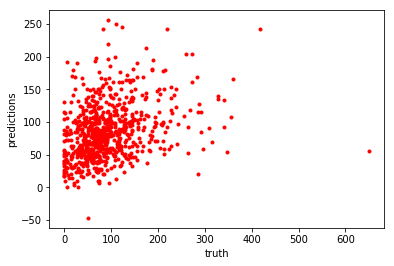

In [30]:
predictionsi, truthi = [int(i) for i in predictions.transpose()[0]], [i for i in y_test_vect[0]]
plt.plot(truthi, predictionsi, 'r.')
plt.ylabel('predictions')
plt.xlabel('truth')
plt.show()

In [28]:
rsquared(truthi, predictionsi)

0.12748859001058499

In [138]:
# Build input layer
def weight_variable(shape):
    initial = tf.random_normal(shape, stddev=0.2)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.001, shape=shape)
    return tf.Variable(initial)

# Build a linear layer
def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

def conv1d(x, W):
    return(tf.nn.conv1d(x, W, stride = 1, padding = 'SAME'))

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[2]]) #check this index
    return tf.nn.relu(conv1d(input, W) + b)

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides = [1,2,2,1], padding='SAME')

In [ ]:
tf.reset_default_graph()
minibatch_size = 32
steps_per_epoch = int(filtered_y.shape[1] / minibatch_size)
epochs = 1000
g=tf.Graph()

with g.as_default():
    training_data = Dataset.from_tensor_slices((filtered_x_vect, filtered_y.transpose()))
    training_data=training_data.batch(minibatch_size).repeat()
    iterator = training_data.make_one_shot_iterator()
    
    steps = epochs*steps_per_epoch
    beta = 0.0001
    batched_x, batched_y = iterator.get_next() 
    tanh = tf.nn.tanh(full_layer(batched_x, 10))
    relu = tf.nn.relu(full_layer(tanh, 10))
    linear = full_layer(relu, 1)

    regularizer = tf.nn.l2_loss(linear)
    mse = tf.losses.mean_squared_error(labels=batched_y, predictions=linear)
    mse = tf.reduce_mean(mse + beta * regularizer)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(mse)
    accuracy = tf.losses.mean_squared_error(labels=batched_y, predictions=linear)
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        if i % 10000 == 0:
            train_accuracy = sess.run(accuracy)
            print("step {}, training accuracy {}".format(i, train_accuracy))
            test_accuracy = np.mean(
        [sess.run(accuracy, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})])
            print("test accuracy: {}".format(test_accuracy))
        sess.run(train_step)
    test_accuracy = np.mean(
        [sess.run(accuracy, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})])
    predictions = sess.run(linear, feed_dict={batched_x: X_test_vect, batched_y: y_test_vect.transpose()})
print("test accuracy: {}".format(test_accuracy))


In [160]:
rsquared(truthi, predictionsi)

0.10615209824128694

In [15]:
def plot_test_epochs(model, result_, subset=None):
    i = 1
    if subset != None:
        result_["history"] = np.take(result_["history"], range(0, len(result_["epoch"]), subset), axis=1)
        result_["epoch"] = result_["epoch"][::subset]
    while i < result_["history"].shape[1]:
        plt.plot(result_["history"][:,0], result_["history"][:,i], 'r.')
        plt.ylabel('y_')
        plt.xlabel('y')
        plt.show()
        print("Epoch " + str(result_["epoch"][i]) + ": R2 = " + str(rsquared(result_["history"][:,0], result_["history"][:,i])))
        print("Epoch " + str(result_["epoch"][i]) + ": MSE = " + str(mean_squared_error(result_["history"][:,0], result_["history"][:,i])))
        i+= 1
#     return result["epoch"]

In [16]:
def rsquared_one_to_many(result_):
    out = []
    truth = result_["history"][:,0]
    for column in range(1, result_["history"][:,1:].shape[1]+1):
        epoch_result = result_["history"][:,column]
        out.append(rsquared(epoch_result, truth))
    print(max(out))
    return out

def mse_one_to_many(result_):
    out = []
    truth = result_["history"][:,0]
    for column in range(1, result_["history"][:,1:].shape[1]+1):
        epoch_result = result_["history"][:,column]
        out.append(mean_squared_error(epoch_result, truth))
    print(min(out))
    return out
